In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

In [3]:
labels = ['glioma','notumor','meningioma','pituitary']

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    #../input/brain-tumor-mri-dataset/Testing
    folderPath = os.path.join('../input/brain-tumor-mri-dataset','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-mri-dataset','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 300/300 [00:02<00:00, 114.70it/s]


In [5]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [6]:
X_train.shape,y_train.shape

((7023, 224, 224, 3), (7023,))

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [8]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)


In [9]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
IMAGE_SIZE = [224, 224]

In [10]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

2022-09-22 19:15:40.598857: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 19:15:40.693351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 19:15:40.694270: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 19:15:40.695564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 1s 0us/step


In [11]:
for layer in vgg19.layers:
    layer.trainable = False

In [12]:
x = Flatten()(vgg19.output)

In [13]:
prediction = Dense(4, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("vgg19_23Sep.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

2022-09-22 19:15:46.393608: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-22 19:15:46.393645: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-09-22 19:15:46.395544: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-09-22 19:15:46.615394: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-22 19:15:46.615573: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [17]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

2022-09-22 19:15:46.839763: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 856203264 exceeds 10% of free system memory.
2022-09-22 19:15:47.799243: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 856203264 exceeds 10% of free system memory.
2022-09-22 19:15:48.522451: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-09-22 19:15:50.050147: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/178 [..............................] - ETA: 29:21 - loss: 12.4653 - accuracy: 0.2188

2022-09-22 19:15:58.548368: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-09-22 19:15:58.548412: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/178 [..............................] - ETA: 1:03 - loss: 19.1855 - accuracy: 0.3281 

2022-09-22 19:15:58.890235: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-09-22 19:15:58.890769: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-09-22 19:15:59.022480: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 143 callback api events and 140 activity events. 
2022-09-22 19:15:59.028804: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-09-22 19:15:59.042780: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_09_22_19_15_59

2022-09-22 19:15:59.045922: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_09_22_19_15_59/2aadc847390e.trace.json.gz
2022-09-22 19:15:59.062534: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

178/178 [==============================] - 28s 104ms/step - loss: 2.6978 - accuracy: 0.8527 - val_loss: 1.5951 - val_accuracy: 0.9082

Epoch 00001: val_accuracy improved from -inf to 0.90823, saving model to vgg19_23Sep.h5
Epoch 2/10
178/178 [==============================] - 15s 87ms/step - loss: 0.6869 - accuracy: 0.9466 - val_loss: 2.7067 - val_accuracy: 0.8797

Epoch 00002: val_accuracy did not improve from 0.90823
Epoch 3/10
178/178 [==============================] - 14s 80ms/step - loss: 0.3422 - accuracy: 0.9726 - val_loss: 0.9076 - val_accuracy: 0.9415

Epoch 00003: val_accuracy improved from 0.90823 to 0.94146, saving model to vgg19_23Sep.h5
Epoch 4/10
178/178 [==============================] - 15s 87ms/step - loss: 0.3433 - accuracy: 0.9738 - val_loss: 2.0912 - val_accuracy: 0.9225

Epoch 00004: val_accuracy did not improve from 0.94146
Epoch 5/10
178/178 [==============================] - 15s 87ms/step - loss: 0.4574 - accuracy: 0.9701 - val_loss: 3.0627 - val_accuracy: 0.90

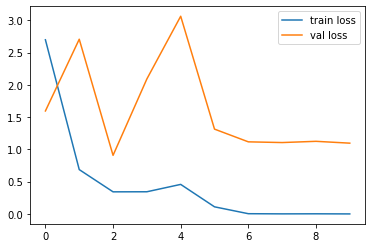

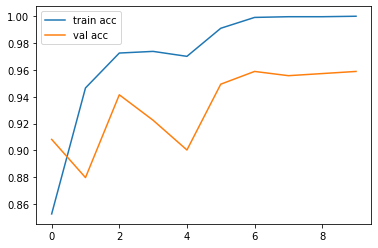

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [20]:
print(y_test_new)

[3 2 0 3 1 0 2 1 0 1 2 1 2 0 1 1 3 0 0 2 2 0 3 2 0 2 0 3 3 3 2 0 0 3 0 0 2
 3 0 2 2 3 0 3 1 1 0 0 0 1 0 1 1 1 2 2 3 0 1 3 2 3 1 0 1 1 1 2 3 3 1 3 0 2
 2 3 2 2 1 0 1 2 1 1 3 3 1 0 3 1 3 3 1 1 1 0 2 3 3 3 2 3 1 1 2 2 2 0 1 1 3
 2 2 3 2 1 0 2 0 1 3 3 2 0 0 3 2 2 2 0 0 1 1 2 1 3 3 2 1 0 0 0 1 3 3 1 0 2
 1 1 1 1 1 3 3 3 3 1 2 1 0 0 3 3 3 0 2 2 1 2 3 1 2 0 3 0 2 2 3 1 0 0 2 3 2
 1 1 1 0 1 0 1 1 2 2 0 0 0 1 3 2 2 3 3 3 0 3 3 3 2 1 1 3 1 2 3 0 3 1 0 2 1
 0 3 1 2 1 0 1 2 2 1 2 2 2 1 3 1 2 2 3 3 2 0 3 3 3 0 1 0 1 1 3 1 3 1 0 2 1
 1 0 1 3 3 2 1 3 0 2 2 3 2 0 3 2 3 1 1 1 2 1 2 0 0 3 0 0 1 1 3 0 1 1 3 2 3
 1 2 2 1 2 3 3 1 1 3 0 3 2 2 0 0 3 1 3 1 2 1 1 2 1 1 0 3 2 3 1 3 2 1 1 1 1
 2 0 0 1 2 1 0 2 0 0 1 2 2 2 1 3 2 0 0 3 2 0 3 1 2 3 3 1 0 1 0 3 1 3 1 2 0
 1 2 1 0 0 0 2 0 3 3 3 0 2 2 2 0 1 1 3 2 0 2 0 1 0 1 2 0 0 1 1 3 3 1 3 2 2
 2 0 2 2 1 1 0 2 2 2 0 1 0 0 2 2 2 1 1 2 1 3 1 0 1 0 1 2 1 1 3 3 0 2 0 1 2
 2 3 1 3 1 0 0 3 1 2 1 2 2 0 0 0 0 1 3 1 1 0 3 2 1 0 3 0 0 2 1 1 1 3 3 2 3
 0 1 0 1 2 0 0 0 0 1 2 0 

In [21]:
labels = ['glioma','notumor','meningioma','pituitary']
print(np.count_nonzero(y_test_new==0))
print(np.count_nonzero(y_test_new==1))
print(np.count_nonzero(y_test_new==2))
print(np.count_nonzero(y_test_new==3))

170
203
174
156


In [22]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       170
           1       1.00      0.98      0.99       203
           2       0.92      0.94      0.93       174
           3       0.96      1.00      0.98       156

    accuracy                           0.96       703
   macro avg       0.96      0.96      0.96       703
weighted avg       0.96      0.96      0.96       703



In [23]:
from tensorflow.keras.models import load_model

model.save('new_vgg19_20sep.h5')

In [24]:
from tensorflow.keras.models import load_model
labels = ['glioma','notumor','meningioma','pituitary']
model1=load_model('./vgg19_23Sep.h5')
import cv2
image = cv2.imread("../input/brain-tumor-mri-dataset/Testing/pituitary/Te-piTr_0001.jpg", 1)
img = cv2.resize(image, (224,224),
               interpolation = cv2.COLOR_RGB2BGR)
img = img.reshape(1,224,224,3)
p = model1.predict(img)
p = np.argmax(p,axis=1)[0]
print(p)

3


In [25]:
img = cv2.resize(image, (224,224),
               interpolation = cv2.COLOR_RGB2BGR)

In [26]:
img = img.reshape(1,224,224,3)

In [27]:
p = model.predict(img)

In [28]:
p = np.argmax(p,axis=1)[0]

In [29]:
print(p)

3
